#### Code for introducing Voltage Dependent Theta Neuron Model into Low Rank Connectivity SNNs  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
class LowRankSNN:
    # CONSTANTS
    G_L_E = 0.08
    G_L_I = 0.1
    G_P= [0.004069, 0.02672, 0.003276, 0.02138] #g_peak:[E←E, E←I, I←E, I←I]
    V_T = -55
    V_R = -62
    REV_E = 0
    REV_I = -70
    BIAS = V_T - V_R #Bias current
    C0 = 2/(V_T-V_R)
    C1 = (2*REV_E-V_R-V_T)/(V_T-V_R)
    C2 = (2*REV_I-V_R-V_T)/(V_T-V_R)

    def __init__(self,N_E=1000,N_I=200,RS= 1,taud_E=2,taud_I=5) -> None:
        self.N_E = N_E
        self.N_I = N_I
        self.RS = RS
        self.taud_E = taud_E
        self.taud_I = taud_I
        self.conn = np.zeros((N_E+N_I,N_E+N_I))
        self.added_lowrank = False
        self.added_random = False
        

    def show(self):
        print('Network Settings')
        print('==========================================')
        print('Number of Neurons: ', self.N_E+self.N_I)
        print('Number of Excitatory Units: ', self.N_E)
        print('Number of Inhibitory Units: ', self.N_I)
        # full_w = torch.mm(self.W, self.mask) #包含兴奋和抑制性信息的连接矩阵
        # full_w = self.W * self.mask
        zero_w = (self.conn == 0).sum().item()
        # pos_w = (self.conn > 0).sum().item()
        # neg_w = (full_w < 0 ).sum().item()
        print('Zero Weights occupy: %2.2f %%'%(zero_w/(self.N**2)*100))
        # print('Positive Weights occupy: %2.2f %%'%(pos_w/(self.N**2)*100))
        # print('Negative Weights occupy: %2.2f %%'%(neg_w/(self.N**2)*100))

    def show_conn(self):
        full_w = self.conn.copy() #包含兴奋和抑制性信息的连接矩阵
        # let the weight from Inhibitory be negative value
        full_w[:,self.N_E:self.N_E+self.N_I] = -full_w[:,self.N_E:self.N_E+self.N_I]
        colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # 蓝 -> 白 -> 红
        cmap_name = 'gradient_div_cmap'
        gradient_cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)  # N=100 使渐变更加平滑
        plt.imshow(full_w,cmap=gradient_cm,vmax=0.001,vmin=-0.001)
        plt.colorbar()
        plt.title('Connectivity Matrix')
        plt.xlabel('From')
        plt.xticks(np.arange(0,len(full_w)+1,500))
        plt.ylabel('To')
        plt.yticks(np.arange(0,len(full_w)+1,500))
        plt.gca().xaxis.set_ticks_position('top')
        plt.gca().xaxis.set_label_position('top')
        plt.show()
        

    def add_random(self,conn_rand):
        self.conn_random = conn_rand
        self.conn += conn_rand*self.RS
        self.added_random = True
        print('Random connection has been added.')
        return

    def remove_random(self):
        if not self.added_random:
            print('There is no random connection added.')
            return
        self.conn -= self.conn_random
        del self.conn_random
        self.added_random = False
        print('Random connection has been removed.')
        return

    def add_lowrank(self,conn_LR, W_out):
        self.conn_lowrank = conn_LR
        self.conn += conn_LR
        self.W_out = W_out
        self.added_lowrank = True
        print('Low Rank connection and readout vector have been added.')
        return

    def remove_lowrank(self):
        if not self.added_lowrank:
            print('There is no Low Rank Connectivity added.')
            return
        self.conn -= self.conn_lowrank
        del self.conn_lowrank
        del self.W_out
        self.added_lowrank = False
        print('Low Rank connection and readout vector have been removed.')

    def V2theta(self,V):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return 2*np.arctan((V-(V_R+V_T)/2)*2/(V_T-V_R))

    def theta2V(self,theta):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return (V_T+V_R)/2+(V_T-V_R)/2*np.tan(theta/2)

    def simulate(self,dt,Input):

        if self.conn_lowrank.shape == self.conn_random.shape:
            print('Low-rank connectivity is added to all the connections')

        G_P = LowRankSNN.G_P
        G_L_E = LowRankSNN.G_L_E
        G_L_I = LowRankSNN.G_L_I
        C0 = LowRankSNN.C0
        C1 = LowRankSNN.C1
        C2 = LowRankSNN.C2
        conn_EE = self.conn[:self.N_E,:self.N_E]
        conn_IE = self.conn[self.N_E:self.N_E+self.N_I,:self.N_E]
        conn_EI = self.conn[:self.N_E,self.N_E:self.N_E+self.N_I]
        conn_II = self.conn[self.N_E:self.N_E+self.N_I,self.N_E:self.N_E+self.N_I]
        V = np.zeros_like(Input)
        phase = np.zeros_like(Input)
        g = np.zeros_like(Input)
        g_EE = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        g_IE = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)
        g_EI = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        g_II = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)
        spk = np.zeros_like(Input)

        for step, inputs in enumerate(Input.T): #for every time step
            if step == 0: continue

            # Calculate Synaptic Conductance (Single Exponential filter)
            g_EE[:,step] = g_EE[:,step-1] + \
                (-g_EE[:,step-1]/self.taud_E+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1])*dt
            g_EI[:,step] = g_EI[:,step-1] + \
                (-g_EI[:,step-1]/self.taud_E+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            g_IE[:,step] = g_IE[:,step-1] + \
                (-g_IE[:,step-1]/self.taud_I+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1])*dt
            g_II[:,step] = g_II[:,step-1] + \
                (-g_II[:,step-1]/self.taud_I+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            # Calculate the comprehensive Synaptic Conductance (Single Exponential filter)
                # For Excitatory Neurons
            g[:self.N_E,step] = g[0:self.N_E,step-1] + \
                (-g[0:self.N_E,step-1]/self.taud_E+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1]+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
                # For Inhibitory Neurons
            g[self.N_E:self.N_E+self.N_I,step] = g[self.N_E:self.N_E+self.N_I,step-1] + \
                (-g[self.N_E:self.N_E+self.N_I,step-1]/self.taud_I+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1]+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt

            if np.any(g<0):
                print('got it')

            # Calculate Membrane Voltage (Phase)
            # For Excitatory Neurons
            phase_pre_E = phase[:self.N_E,step-1]
            phase[:self.N_E,step] = phase_pre_E + (-G_L_E*np.cos(phase_pre_E)+C0*(1+np.cos(phase_pre_E))*inputs[:self.N_E]+g_EE[:,step]*(C1*(1+np.cos(phase_pre_E))-\
                np.sin(phase_pre_E))+g_EI[:,step]*(C2*(1+np.cos(phase_pre_E))-np.sin(phase_pre_E)))*dt
            # For Inhibitory Neurons
            phase_pre_I = phase[self.N_E:self.N_E+self.N_I,step-1]
            phase[self.N_E:self.N_E+self.N_I,step] = phase_pre_I + (-G_L_I*np.cos(phase_pre_I)+C0*(1+np.cos(phase_pre_I))*inputs[self.N_E:self.N_E+self.N_I]+g_IE[:,step]*(C1*(1+np.cos(phase_pre_I))-\
                np.sin(phase_pre_I))+g_II[:,step]*(C2*(1+np.cos(phase_pre_I))-np.sin(phase_pre_I)))*dt

            # Store the firing time
            spk[:,step] = (phase[:,step] >= np.pi).astype(int)
            phase[:,step][phase[:,step] >= np.pi] -= 2*np.pi
            

        if self.conn_lowrank.shape == self.conn_random.shape:
            Out = np.dot(g.T,self.W_out)/(self.N_E+self.N_I) #Size of g:(N,time), Size of W_out: (N,1)
        V = self.theta2V(phase)
        return Out, V, g, spk



In [3]:
# Function
def Draw_Output(ax,data,color_data,label_data,dt,input_data):
    # tt = np.linspace(0,len(data)-1)*dt
    tt = np.array(range(len(data)))*dt
    ax.plot(tt,data,color = color_data, label = '$'+label_data+'$')

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Read Out')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([0, np.max([0.00001,np.max(data),ax.get_ylim()[1]])])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-2,1,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})

def Draw_Conductance(ax,data,color_data,label_data,dt,input_data):
    tt = np.array(range(len(data[0])))*dt
    if type(label_data) == list:
        for i in range(len(data)):
            ax.plot(tt,data[i],color = color_data, label = '$'+label_data+'$')
    else:
        ax.plot(tt,np.mean(data,axis=0),color = color_data, label = '$'+label_data+'$')

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Synaptic Conductance (mS/cm^2)')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([0, np.max([0.000001,np.max(data),ax.get_ylim()[1]])])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-2,1,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})


def Draw_RasterPlot(ax,data,title_name,dt,input_data,N_E,N_I):
    tt = np.array(range(len(data[0])))*dt
    #Exc
    for row in range(data.shape[0]-N_I):
        spike_times = np.where(data[row]==1)[0]
        # ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, marker='|',color = 'red')
        ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, color = 'red',s=5)

    #Inh
    for row in range(N_E,data.shape[0]):
        spike_times = np.where(data[row]==1)[0]
        # ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, marker='|',color = 'blue')
        ax.scatter(spike_times*dt, np.ones_like(spike_times) * row, color = 'blue',s=5)

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Neuron Index')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([-1, N_E+N_I])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-1,N_E+N_I,alpha = 0.1)
    # ax.legend(loc = 1, prop={'size':10})
    ax.set_title(title_name)



def Draw_Voltage(ax,data,color_data,label_data,dt,input_data):
    print(len(data) == 0)
    if len(data) == 0: return
    tt = np.array(range(len(data[0])))*dt
    
    if type(label_data) == list:
        for i in range(len(data)):
            ax.plot(tt,data[i],color = color_data, label = '$'+label_data+'$')
    else:
        ax.plot(tt,data[0],color = color_data, label = '$'+label_data+'$')
        for i in range(1,len(data)):
            ax.plot(tt,data[i],color = color_data)

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Voltage (mV)')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([-100, 10])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between([start_sti,end_sti],-100,100,alpha = 0.1)
    ax.legend(loc = 1, prop={'size':10})
    # ax.legend()


Low Rank connection and readout vector have been added.
Random connection has been added.


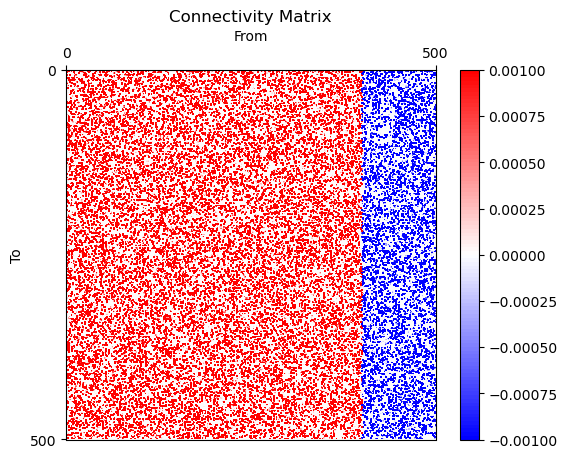

In [4]:
# Initialiazation
# LRSNN = LowRankSNN(N_E=4000,N_I=1000,RS= 1,taud_E=2,taud_I=5)
# LRSNN = LowRankSNN(N_E=5000,N_I=0,RS= 1,taud_E=2,taud_I=5)
LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 1,taud_E=2,taud_I=5)
#low rank文献的N=5000
# Go_NoGo Task
# Prepare the Stimuli and Readout Vector
temp = np.random.rand(1,LRSNN.N_E+LRSNN.N_I) #Size (1,N_E) for Sti_go and nogo #这里我想试试把Low Rank加到整个网络上
Sti_go = temp.copy()
Sti_nogo = temp.copy()
W_out = temp.copy()
Sti_go[Sti_go>1/3] = 0
Sti_nogo[Sti_nogo<1/3] = 0
Sti_nogo[Sti_nogo>2/3] = 0
W_out[W_out<2/3] = 0

# Use Gamma Distribution to generate Stimuli and Readout Vector
# mean and std of Gamma Distribution(Deside Sti_go,Sti_nogo,W_out,conn_rand)
mu = 1
si = 10
b = si**2/mu
a = mu/b

Sti_go[Sti_go!=0] = np.random.gamma(a,b,len(np.nonzero(Sti_go)[0])) #random.gamma(shape(a), scale(b)=1.0, size=None),这个地方的Gamma分布及其参数选取需要进一步讨论
Sti_nogo[Sti_nogo!=0] = np.random.gamma(a,b,len(np.nonzero(Sti_nogo)[0]))
W_out[W_out!=0] = np.random.gamma(a,b,len(np.nonzero(W_out)[0]))
W_out = np.transpose(W_out) #Size (N_E,1)
# Low Rank Connectivity (Rank = 1)
conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数?
# Random Connectivity
conn_rand = np.random.gamma(a,b,(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I)) #这里的Gamma分布取值也需要讨论

# # Use Folded Gaussian Distribution to generate Stimuli and Readout Vector
# std_Sti = 2. #Standerd Deviration of Stimuli
# std_Wout = 2. #Standerd Deviration of readout matrix
# Sti_go[Sti_go!=0] = np.abs(np.random.normal(0,std_Sti,len(np.nonzero(Sti_go)[0]))) 
# Sti_nogo[Sti_nogo!=0] = np.abs(np.random.normal(0,std_Sti,len(np.nonzero(Sti_nogo)[0])))
# W_out[W_out!=0] = np.abs(np.random.normal(0,std_Wout,len(np.nonzero(W_out)[0])))
# W_out = np.transpose(W_out) #Size (N,1)

# conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数? # Low Rank Connectivity (Rank = 1)
# conn_rand = np.abs(np.random.normal(0,1/(LRSNN.N_E+LRSNN.N_I),(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I))) # Random Connectivity

m = W_out #m = Wout
n = Sti_go #n = Stigo

# Assemble the Network
LRSNN.add_lowrank(conn_LR, W_out)
LRSNN.add_random(conn_rand)
# Show the Network information before simulaiton
LRSNN.show_conn()



In [5]:
dt = 0.01 #(ms/step)
T_pre = 5 # length of time before sti (ms)
T_sti = 10 # length of time for sti (ms)
T_after = 15 # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms
IS = 1 #Input Strength

Input_go = np.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go.T
Input_nogo = np.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo.T

# Simulation
Out_go, V_go, g_go, spk_go = LRSNN.simulate(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN.simulate(dt,Input_nogo)

prop = max(Out_go)/max(Out_nogo)
print('Performance: ', prop[0])

Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Performance:  42.60843085766093


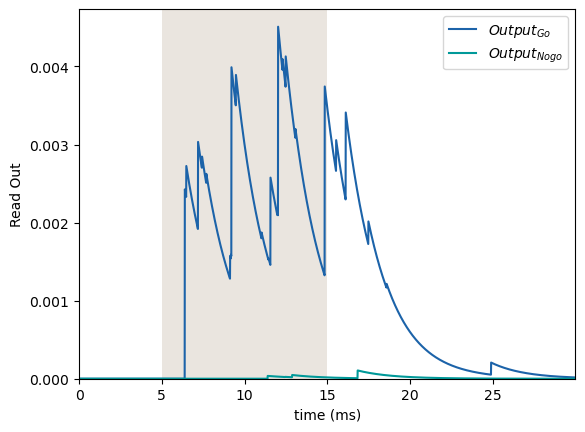

In [6]:
# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,color_Go,'Output_{Go}',dt,Input_go)
Draw_Output(ax,Out_nogo,color_Nogo,'Output_{Nogo}',dt,Input_nogo)

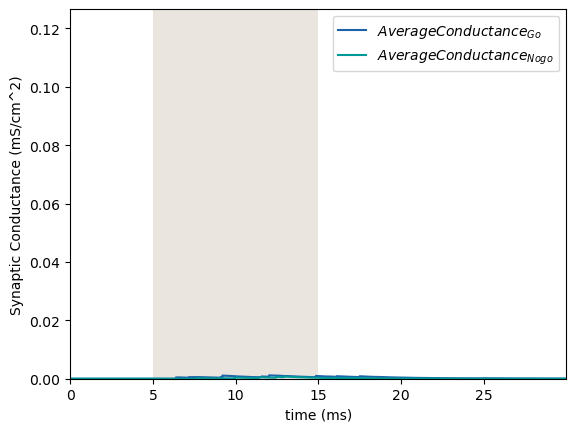

In [7]:
# Monitor the Average Conductance
fig, ax = plt.subplots()

Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go)
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo)

False
False
False
False


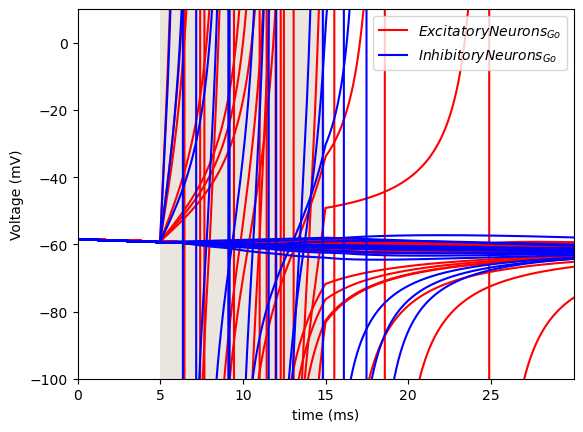

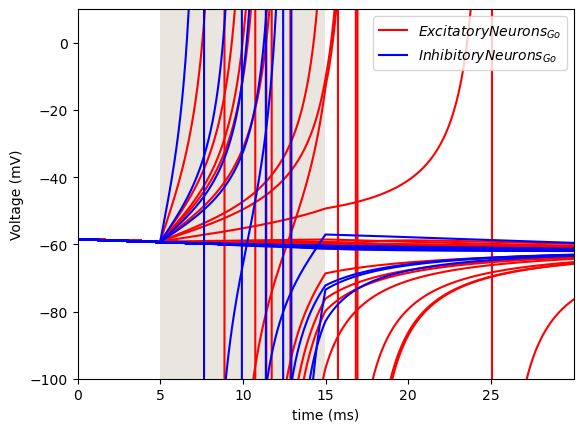

In [8]:
# Monitor the Voltage
fig, ax = plt.subplots()
Draw_Voltage(ax,V_go[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_go)
Draw_Voltage(ax,V_go[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_go)
fig, ax = plt.subplots()
Draw_Voltage(ax,V_nogo[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_nogo)
Draw_Voltage(ax,V_nogo[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_nogo)


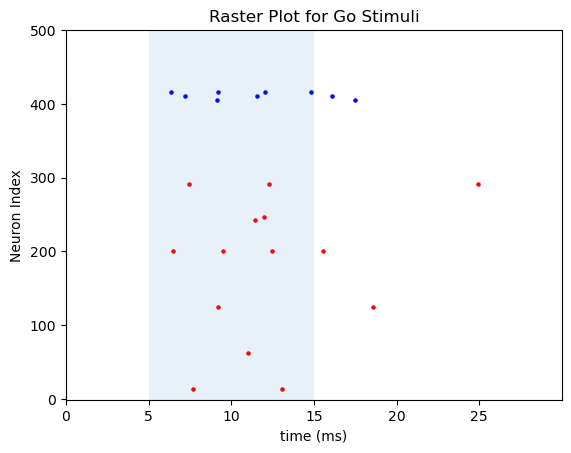

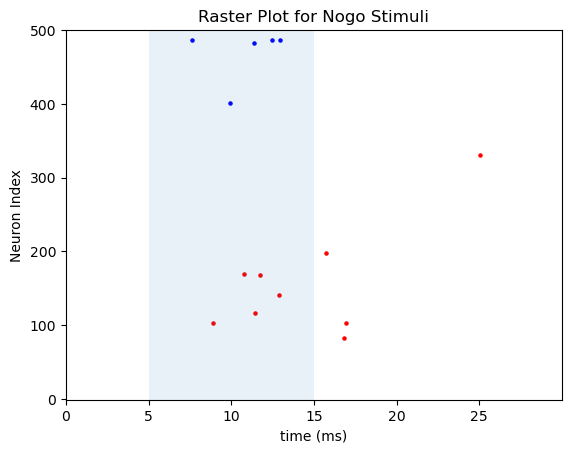

In [9]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E,LRSNN.N_I)
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E,LRSNN.N_I)




In [10]:
# 改变来自抑制性神经元的所有连接
# conn_EI = LRSNN.conn[:LRSNN.N_E,LRSNN.N_E:]
# conn_II = LRSNN.conn[LRSNN.N_E:,LRSNN.N_E:]
conn_I = LRSNN.conn[:,LRSNN.N_E:].copy()
conn_IE = LRSNN.conn[LRSNN.N_E:,:LRSNN.N_E].copy()
conn_EE = LRSNN.conn[:LRSNN.N_E,:LRSNN.N_E].copy()
# LRSNN.conn[:,LRSNN.N_E:] = conn_I.copy()*0
# LRSNN.conn[LRSNN.N_E:,:LRSNN.N_E] = conn_IE.copy()*0
# LRSNN.conn[:LRSNN.N_E,:LRSNN.N_E] = conn_EE.copy()*0


Out_go, V_go, g_go, spk_go = LRSNN.simulate(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN.simulate(dt,Input_nogo)
prop = max(Out_go)/max(Out_nogo)

LRSNN.conn[:,LRSNN.N_E:] = conn_I.copy()
LRSNN.conn[LRSNN.N_E:,:LRSNN.N_E] = conn_IE.copy()
LRSNN.conn[:LRSNN.N_E,:LRSNN.N_E] = conn_EE.copy()
print('Performance: ', prop)

Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections
Performance:  [42.60843086]


In [11]:
conn_I

array([[2.70737315e-004, 2.49450194e-010, 5.91704753e-015, ...,
        4.24746219e-053, 3.00797810e-123, 5.12005749e-069],
       [1.29127605e-028, 2.87135024e-135, 1.42796871e-002, ...,
        7.93074253e-053, 2.01628018e-050, 8.16508894e-033],
       [1.11519771e-025, 1.65440057e-062, 9.90352791e-021, ...,
        9.27817855e-038, 1.42852334e-007, 4.61753290e-013],
       ...,
       [3.58651854e-014, 9.14469503e-020, 1.20854160e-002, ...,
        1.48939654e-040, 1.40653261e-001, 6.56036417e-011],
       [7.43510409e-002, 2.19354136e-027, 4.19560450e-117, ...,
        1.86147538e-036, 2.77090982e-003, 1.67873741e-089],
       [2.74435186e-103, 1.87583952e-021, 8.32354245e-032, ...,
        4.89300284e-080, 5.10312422e-028, 4.31279358e-044]])

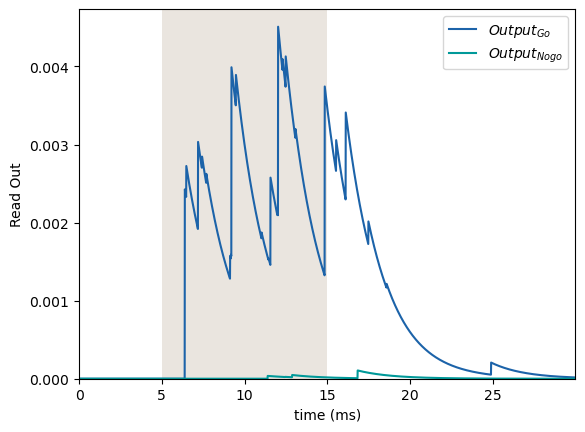

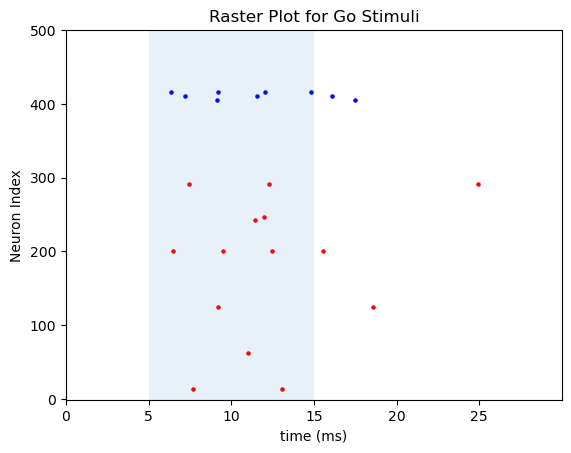

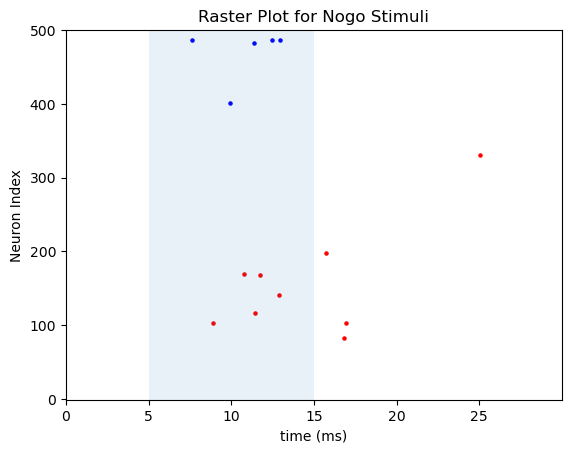

In [12]:
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,color_Go,'Output_{Go}',dt,Input_go)
Draw_Output(ax,Out_nogo,color_Nogo,'Output_{Nogo}',dt,Input_nogo)
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E,LRSNN.N_I)
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E,LRSNN.N_I)

In [13]:
# 0: 6.260
# 0.5: 6.172
# 0.7: 6.290
# 1: 5.989
# 1.3: 6.199
# 1.5: 6.086
# 2.0: 5.926
# 10: 6.260
